# L1 norm prior experiment

This code attempts to learn the 16D prior
$J(x) = ||x||_1$
assuming we have access to training data $\{y_i, S(y_i)\}$, $S(y_i)$- using Huber function 

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/L1_prior_16D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,t=1.0):
    # Section 3.1: Convex Prior J(x) = ||x||_1
    # S(x,t) is the Moreau Envelope of the L1 norm (Huber function).
    # Per component j: if |x_j| > t: |x_j| - t/2. If |x_j| <= t: x_j^2 / 2t
    
    abs_y = np.abs(y)
    # Mask for |x| <= t
    small_mask = abs_y <= t
    
    # Component-wise values
    comps = np.zeros_like(y)
    comps[small_mask] = (abs_y[small_mask]**2) / (2 * t)
    comps[~small_mask] = abs_y[~small_mask] - (t / 2.0)
    
    # Sum across dimensions (separable)
    return np.sum(comps, axis=1)


def prior_true(y):
    # J(x) = ||x||_1
    return np.sum(np.abs(y), axis=1)


def cvx_true(y,t=1.0):
    '''
    Computes Psi(y) = 0.5*||y||^2 - S(y,t).
    The target convex function to learn.
    '''
    return 0.5 * euclid_norm_sq(y) - hjsol_true(y, t)


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,t=1.0) 
    x2_0_cvx_true = cvx_true(x2_0_points,t=1.0)

    x1_0_prior_true = prior_true(x1_0_points)
    x2_0_prior_true = prior_true(x2_0_points)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_cvx_est, "-", label="LPN")
    plt.plot(xi, x1_0_cvx_true, "--", label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the convex function, Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Convex functions(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_cvx_est, "-", label="LPN")
        plt.plot(xi, x2_0_cvx_true, "--", label="Ref")
        plt.grid(True)
        plt.title(f"Cross sections ($0,x_2$,0) of the convex function, Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Convex functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_prior_est, "-",label="LPN")
    plt.plot(xi, x1_0_prior_true, "-",label="Ref")
    plt.grid(True)
    plt.title(f"Cross sections ($x_1$,0) of the prior function,Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_prior_est, "-", label="LPN")
        plt.plot(xi, x2_0_prior_true, "-", label="Ref")
        plt.grid("on")
        plt.title(f"Cross sections ($0,x_2$,0) of the prior function,Dim {dim}")
        plt.xlabel('$x_1$')
        plt.ylabel('Prior functions ($0,x_2$,0)')
        plt.legend()
    plt.tight_layout()

def plot_all(model,a,spacing,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 16

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 30000
Iterations = 500000

# LPN model parameters
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,t=1.0).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 370.77520751953125
iteration 0 loss 338.511474609375


iteration 5000 loss 0.5523096323013306


iteration 10000 loss 0.4466637670993805


iteration 15000 loss 0.37827885150909424


iteration 20000 loss 0.34229615330696106


iteration 25000 loss 0.30459967255592346


iteration 30000 loss 0.2715967297554016


iteration 35000 loss 0.10267088562250137


iteration 40000 loss 0.02655996009707451


iteration 45000 loss 0.018329482525587082


iteration 50000 loss 0.014712471514940262


iteration 55000 loss 0.012010202743113041


iteration 60000 loss 0.010779942385852337


iteration 65000 loss 0.009749701246619225


iteration 70000 loss 0.008988915011286736


iteration 75000 loss 0.008282451890408993


iteration 80000 loss 0.007847890257835388


iteration 85000 loss 0.007330566644668579


iteration 90000 loss 0.007157512474805117


iteration 95000 loss 0.006660557352006435


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.006399195641279221


iteration 105000 loss 0.006097517907619476


iteration 110000 loss 0.005751268472522497


iteration 115000 loss 0.005486736074090004


iteration 120000 loss 0.005291013512760401


iteration 125000 loss 0.00509886397048831


iteration 130000 loss 0.004942697938531637


iteration 135000 loss 0.004777806811034679


iteration 140000 loss 0.004656292963773012


iteration 145000 loss 0.004524902440607548


iteration 150000 loss 0.00441863015294075


iteration 155000 loss 0.004309475421905518


iteration 160000 loss 0.004209761042147875


iteration 165000 loss 0.0041147805750370026


iteration 170000 loss 0.004033158998936415


iteration 175000 loss 0.0039535751566290855


iteration 180000 loss 0.0038740672171115875


iteration 185000 loss 0.003796845441684127


iteration 190000 loss 0.0037246993742883205


iteration 195000 loss 0.0036462596617639065


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.003561898833140731


iteration 205000 loss 0.0035103270784020424


iteration 210000 loss 0.0034133947920054197


iteration 215000 loss 0.0033302775118499994


iteration 220000 loss 0.0032437434419989586


iteration 225000 loss 0.0031723054125905037


iteration 230000 loss 0.003084963420405984


iteration 235000 loss 0.003019442316144705


iteration 240000 loss 0.0029521179385483265


iteration 245000 loss 0.0028835199773311615


iteration 250000 loss 0.002829975914210081


iteration 255000 loss 0.002773274201899767


iteration 260000 loss 0.002716795774176717


iteration 265000 loss 0.00266376044601202


iteration 270000 loss 0.0026137491222471


iteration 275000 loss 0.0025728929322212934


iteration 280000 loss 0.0025257375091314316


iteration 285000 loss 0.0024809956084936857


iteration 290000 loss 0.0024460642598569393


iteration 295000 loss 0.0024088623467832804


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.002370078582316637


iteration 305000 loss 0.00235180975869298


iteration 310000 loss 0.0023140814155340195


iteration 315000 loss 0.0022786192130297422


iteration 320000 loss 0.002245064591988921


iteration 325000 loss 0.002213047817349434


iteration 330000 loss 0.002182208700105548


iteration 335000 loss 0.0021523500327020884


iteration 340000 loss 0.002123244572430849


iteration 345000 loss 0.002095020143315196


iteration 350000 loss 0.0020676557905972004


iteration 355000 loss 0.0020410523284226656


iteration 360000 loss 0.002015472389757633


iteration 365000 loss 0.001990427728742361


iteration 370000 loss 0.0019660417456179857


iteration 375000 loss 0.001942334813065827


iteration 380000 loss 0.001919211819767952


iteration 385000 loss 0.0018967025680467486


iteration 390000 loss 0.0018748100847005844


iteration 395000 loss 0.0018535573035478592


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.001832808367908001


iteration 405000 loss 0.001829729531891644


iteration 410000 loss 0.0018260335782542825


iteration 415000 loss 0.0018224423984065652


iteration 420000 loss 0.0018189174588769674


iteration 425000 loss 0.0018154451390728354


iteration 430000 loss 0.0018120144959539175


iteration 435000 loss 0.0018086214549839497


iteration 440000 loss 0.0018052569357678294


iteration 445000 loss 0.0018019172130152583


iteration 450000 loss 0.0017986046150326729


iteration 455000 loss 0.001795312506146729


iteration 460000 loss 0.0017920478712767363


iteration 465000 loss 0.001788806403055787


iteration 470000 loss 0.001785587053745985


iteration 475000 loss 0.0017823879607021809


iteration 480000 loss 0.001779207494109869


iteration 485000 loss 0.00177604123018682


iteration 490000 loss 0.0017728935927152634


iteration 495000 loss 0.0017697613220661879


L2 loss -- Plot

loss -10.392093658447266


loss -119.28880310058594


loss -211.74501037597656


loss -297.6446838378906


loss -370.4954833984375


loss -425.0364990234375


loss -462.3497619628906


loss -485.44073486328125


loss -498.3780517578125


loss -505.91070556640625


loss -511.4120178222656


loss -516.4195556640625


loss -521.4517822265625


loss -526.6551513671875


loss -532.0493774414062


loss -537.611083984375


loss -543.3046875


loss -549.0936279296875


loss -554.9445190429688


loss -560.8279418945312


loss -566.7194213867188


loss -572.5999145507812


loss -578.4552612304688


loss -584.2756958007812


loss -590.0546875


loss -595.7883911132812


loss -601.4754638671875


loss -607.1156616210938


loss -612.711181640625


loss -618.2644653320312


loss -623.7781982421875


loss -629.2549438476562


loss -634.6966552734375


loss -640.104248046875


loss -645.4783325195312


loss -650.818359375


loss -656.1234130859375


loss -661.39306640625


loss -666.6260986328125


loss -671.8204345703125


final mse:  0.003933800850063562
max, min: 18.35887 -18.320007
loss -10.392093658447266


loss -117.92631530761719


loss -212.32290649414062


loss -301.02935791015625


loss -373.65789794921875


loss -427.14788818359375


loss -465.15533447265625


loss -489.1180114746094


loss -503.5412292480469


loss -512.3619995117188


loss -518.445068359375


loss -523.3385009765625


loss -527.781982421875


loss -532.0917358398438


loss -536.390869140625


loss -540.7181396484375


loss -545.0742797851562


loss -549.4449462890625


loss -553.8120727539062


loss -558.1593627929688


loss -562.4741821289062


loss -566.7485961914062


loss -570.9783325195312


loss -575.161865234375


loss -579.29931640625


loss -583.3917236328125


loss -587.4404296875


loss -591.4473876953125


loss -595.4141845703125


loss -599.3425903320312


loss -603.2340087890625


loss -607.08935546875


loss -610.910400390625


loss -614.6973266601562


loss -618.4512939453125


loss -622.1737060546875


loss -625.86474609375


loss -629.5259399414062


loss -633.1582641601562


loss -636.7613525390625


final mse:  0.0023332114797085524
max, min: 17.937164 -18.257845


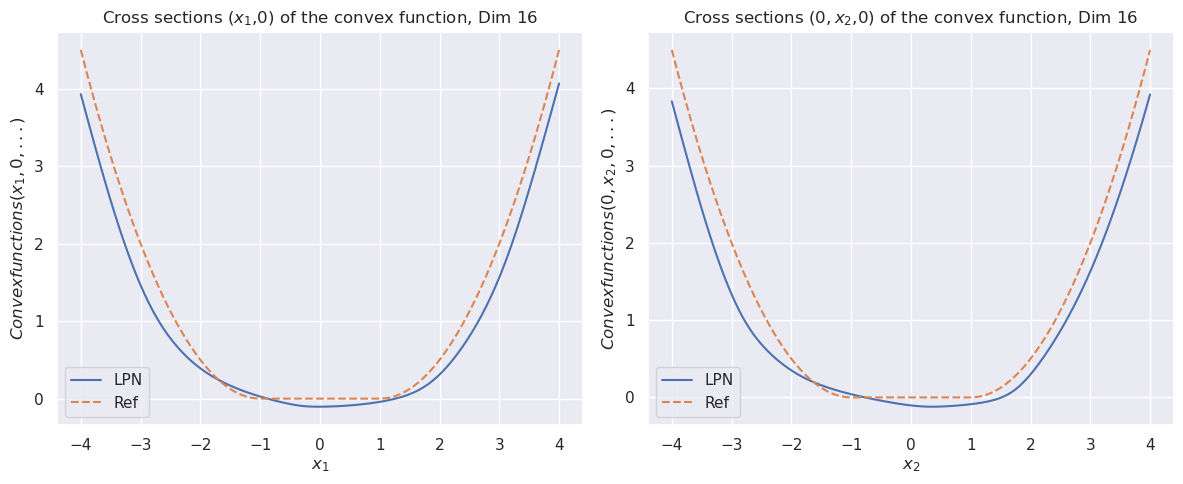

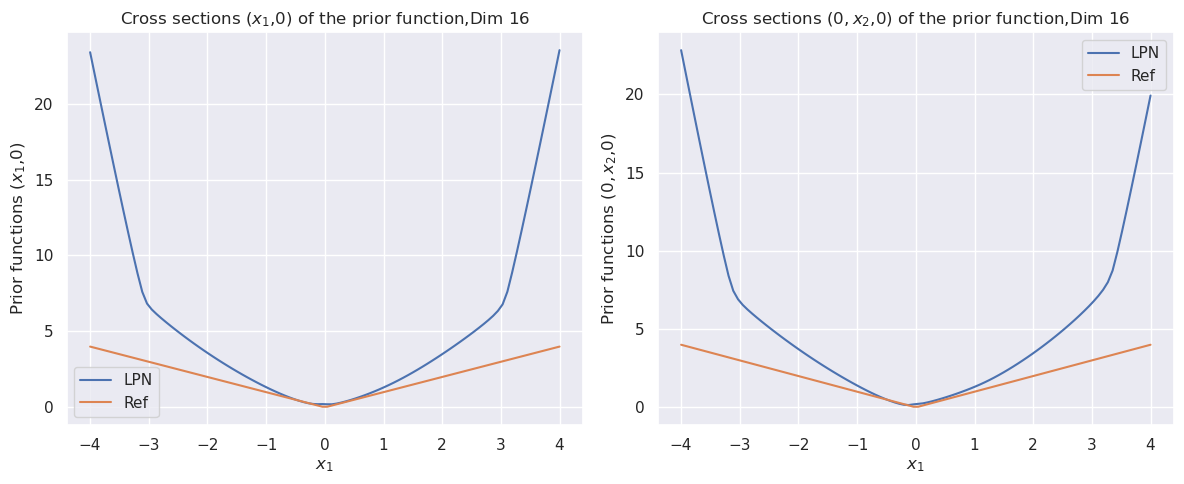

In [7]:
plot_all(lpn_model,a,spacing,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device)

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)

# --- Train 2nd LPN ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1335.3624267578125
iteration 0 loss 110.5156478881836


iteration 5000 loss 0.0486634187400341


iteration 10000 loss 0.027053773403167725


iteration 15000 loss 0.02100312151014805


iteration 20000 loss 0.01760518178343773


iteration 25000 loss 0.015355084091424942


iteration 30000 loss 0.020037250593304634


iteration 35000 loss 0.012156475335359573


iteration 40000 loss 0.011130592785775661


iteration 45000 loss 0.024358145892620087


iteration 50000 loss 0.009851500391960144


iteration 55000 loss 0.009208565577864647


iteration 60000 loss 0.00822885986417532


iteration 65000 loss 0.008435260504484177


iteration 70000 loss 0.0073305717669427395


iteration 75000 loss 0.0067925783805549145


iteration 80000 loss 0.006429035682231188


iteration 85000 loss 0.006056420039385557


iteration 90000 loss 0.005753017030656338


iteration 95000 loss 0.005809911992400885


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.005386267323046923


iteration 105000 loss 0.004885054659098387


iteration 110000 loss 0.004577917978167534


iteration 115000 loss 0.004344485700130463


iteration 120000 loss 0.004148650448769331


iteration 125000 loss 0.003969103563576937


iteration 130000 loss 0.0038172274362295866


iteration 135000 loss 0.003679807297885418


iteration 140000 loss 0.003550836583599448


iteration 145000 loss 0.00342354248277843


iteration 150000 loss 0.003313005669042468


iteration 155000 loss 0.00321497512049973


iteration 160000 loss 0.00312247546389699


iteration 165000 loss 0.0030318701174110174


iteration 170000 loss 0.0029454687610268593


iteration 175000 loss 0.0028681661933660507


iteration 180000 loss 0.0027911062352359295


iteration 185000 loss 0.0027231103740632534


iteration 190000 loss 0.0026506383437663317


iteration 195000 loss 0.0025850185193121433


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.002523819450289011


iteration 205000 loss 0.0024887635372579098


iteration 210000 loss 0.00243241130374372


iteration 215000 loss 0.002372876973822713


iteration 220000 loss 0.002326754853129387


iteration 225000 loss 0.0022721339482814074


iteration 230000 loss 0.002223320072516799


iteration 235000 loss 0.0021754750050604343


iteration 240000 loss 0.002127183834090829


iteration 245000 loss 0.002083933213725686


iteration 250000 loss 0.0020424192771315575


iteration 255000 loss 0.001999848522245884


iteration 260000 loss 0.0019637909717857838


iteration 265000 loss 0.001926662866026163


iteration 270000 loss 0.00189251231495291


iteration 275000 loss 0.0018574048299342394


iteration 280000 loss 0.0018205882515758276


iteration 285000 loss 0.0017870835727080703


iteration 290000 loss 0.0017585543682798743


iteration 295000 loss 0.0017281209584325552


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0016999555518850684


iteration 305000 loss 0.001688293064944446


iteration 310000 loss 0.0016533562447875738


iteration 315000 loss 0.0016211697366088629


iteration 320000 loss 0.0015886994078755379


iteration 325000 loss 0.0015572950942441821


iteration 330000 loss 0.0015277763595804572


iteration 335000 loss 0.001498641213402152


iteration 340000 loss 0.0014712328556925058


iteration 345000 loss 0.0014446643181145191


iteration 350000 loss 0.001418905914761126


iteration 355000 loss 0.001393961487337947


iteration 360000 loss 0.0013697821414098144


iteration 365000 loss 0.0013471903512254357


iteration 370000 loss 0.001324597978964448


iteration 375000 loss 0.0013028191169723868


iteration 380000 loss 0.001281724194996059


iteration 385000 loss 0.0012619496555998921


iteration 390000 loss 0.0012426883913576603


iteration 395000 loss 0.001223623170517385


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0012051780940964818


iteration 405000 loss 0.0012008209014311433


iteration 410000 loss 0.001193418400362134


iteration 415000 loss 0.0011862090323120356


iteration 420000 loss 0.0011791662545874715


iteration 425000 loss 0.0011722577037289739


iteration 430000 loss 0.0011654611444100738


iteration 435000 loss 0.0011587688932195306


iteration 440000 loss 0.001152167678810656


iteration 445000 loss 0.0011456485372036695


iteration 450000 loss 0.0011392112355679274


iteration 455000 loss 0.001132854726165533


iteration 460000 loss 0.0011265735374763608


iteration 465000 loss 0.0011203676695004106


iteration 470000 loss 0.0011142271105200052


iteration 475000 loss 0.0011081506963819265


iteration 480000 loss 0.0011021377285942435


iteration 485000 loss 0.0010961901862174273


iteration 490000 loss 0.001090301782824099


iteration 495000 loss 0.0010844654170796275


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


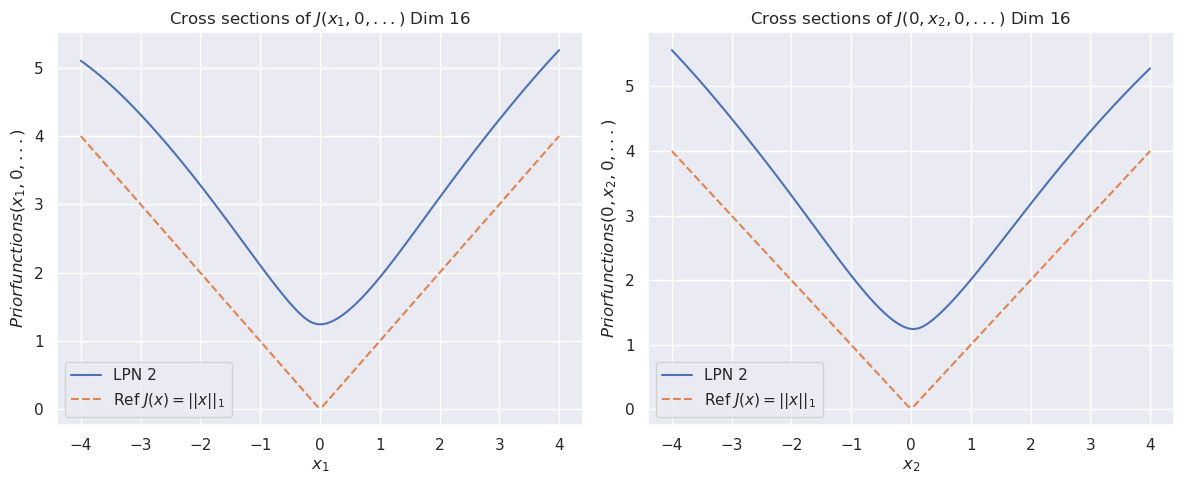

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=||x||_1$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=||x||_1$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim)